# Image similarity for product recommendation.

Online shopping websites always suggest items similar to the ones you have browsed and sometimes even items that can go with it. This notebook is a basic replication of the product recommendations using cosine image similarity. This topic falls majorly in the domain of Recommendation sytems, and I have a whole notebook dedicated to the topic. [Check it out!](https://www.kaggle.com/niharika41298/recommendation-systems-in-a-nutshell)

![Image](https://1030z2bnst92zo6j523feq9e-wpengine.netdna-ssl.com/wp-content/uploads/2020/02/product-recommendations-hero.png)

# Dash User Interface

* Dash is basically a platform by the renowned Plotly library,which many data scientists use as a User Interface.
* Dash uses Flask as the base framework and creates a web application where data scientists and analysts can display visualizations, text or any such asset. Dash is completely in Python so you do not have to worry about learning JavaScript. It is the nearest equivalent of the R Shiny platform.
* Here is the static application for product recommendations that uses the vgg16 model to get recommendations.


(Click on the below image)

[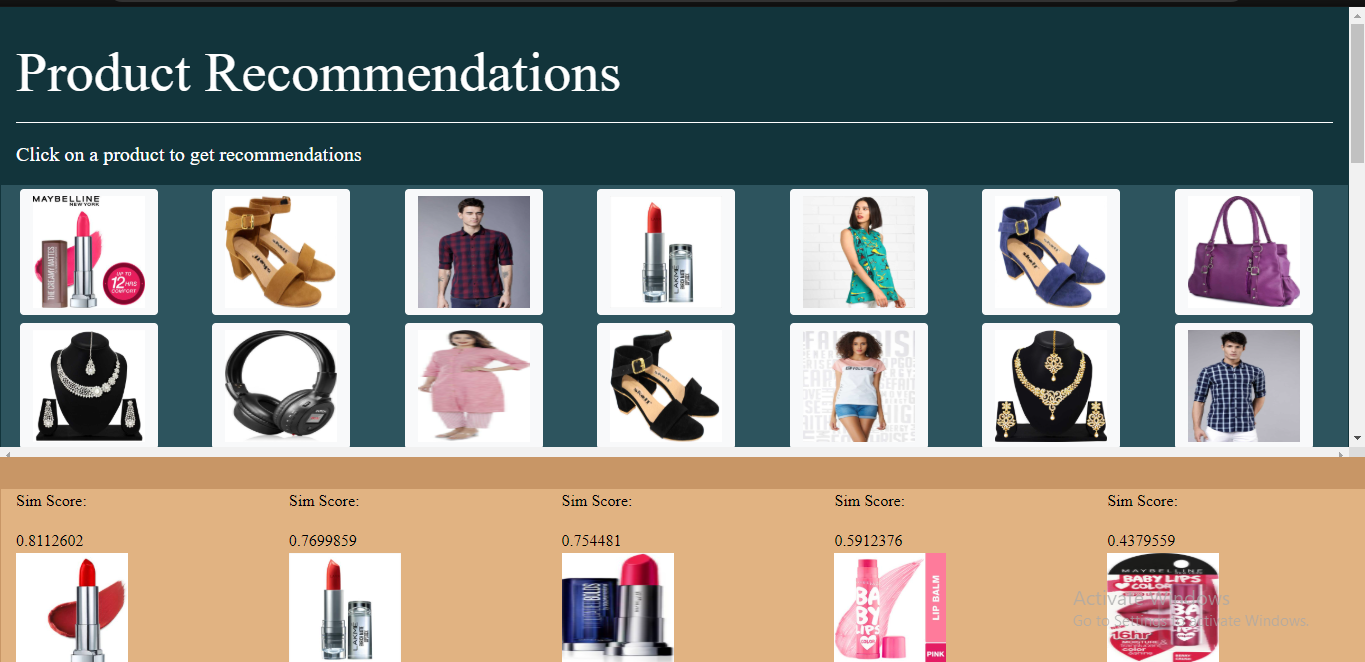](https://productrecom-n.herokuapp.com/)




# About the VGG16 Model

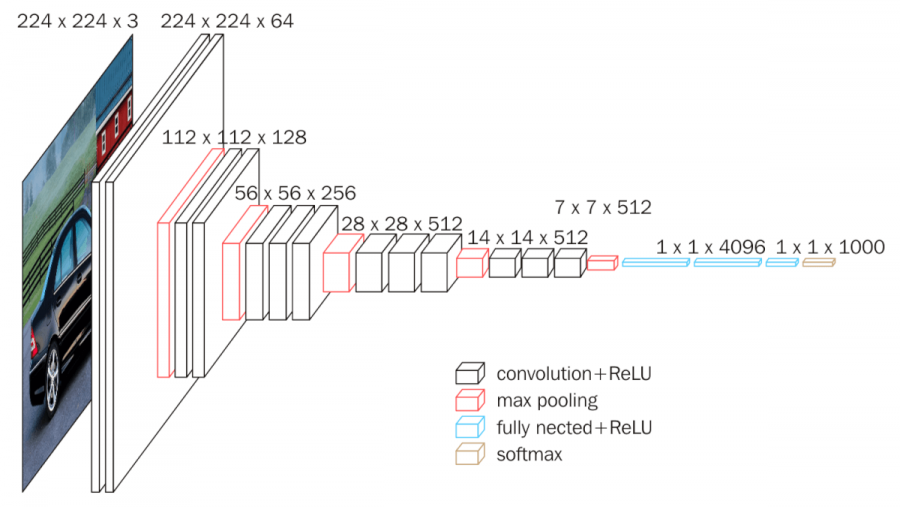

VGG16 is a convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”. The model achieves 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes.VGG16 was trained for weeks and was using NVIDIA Titan Black GPU’s.It always uses 3 x 3 filters with stride of 1 in convolution layer and uses SAME padding in pooling layers 2 x 2 with stride of 2.

Here, the last softmax layer is not required as classification is not performed. Therefore, for feature extraction the outputs are from the fc2 layer.

# Transfer learning model VGG16 for the above User Interface.

First step, importing all necessary libraries.

In [ ]:
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np

from keras.applications import vgg16
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input


from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

**Getting images and setting height and weight.** Note that here VGG16 Transfer learning model is being used and the architecture of the model informs that the first input layer accepts input in the shape of (none, 224,224,3). Therefore, the shape of the images is 224,224.

In [ ]:
imgs_path = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/fashion-dataset/images/"
imgs_model_width, imgs_model_height = 224, 224
nb_closest_images = 5

In [ ]:
files = [imgs_path + x for x in os.listdir(imgs_path) if "jpg" in x]

print("Total number of images:",len(files))

In [ ]:
#For reducing compilation time of the algorithm, we reduce the data to 5000 images or the system crashes!
files=files[0:5000]

## Testing feature extraction with one image

In [ ]:
original = load_img(files[9], target_size=(imgs_model_width, imgs_model_height))
plt.imshow(original)
plt.show()
print("Image loaded successfully!")

In [ ]:
# load the model
vgg_model = vgg16.VGG16(weights='imagenet')

# remove the last layers in order to get features instead of predictions
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)

# print the layers of the CNN
feat_extractor.summary()

In [ ]:
numpy_image = img_to_array(original)
# convert the image / images into batch format
# expand_dims will add an extra dimension to the data at a particular axis
# we want the input matrix to the network to be of the form (batchsize, height, width, channels)
# thus we add the extra dimension to the axis 0.
image_batch = np.expand_dims(numpy_image, axis=0)
print('Image Batch size', image_batch.shape)

# prepare the image for the VGG model
processed_image = preprocess_input(image_batch.copy())

In [ ]:
img_features = feat_extractor.predict(processed_image)

print("Features successfully extracted for one image!")
print("Number of image features:",img_features.size)
img_features

## Because the algorithm works for one image, it should work for a batch of images, let us try!

In [ ]:
importedImages = []

for f in files:
    filename = f
    original = load_img(filename, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    
    importedImages.append(image_batch)
    
images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())

In [ ]:
imgs_features = feat_extractor.predict(processed_imgs)

print("features successfully extracted!")
imgs_features.shape

In [ ]:
cosSimilarities = cosine_similarity(imgs_features)

# store the results into a pandas dataframe

cos_similarities_df = pd.DataFrame(cosSimilarities, columns=files, index=files)
cos_similarities_df.head()

In [ ]:
# function to retrieve the most similar products for a given one

def retrieve_most_similar_products(given_img):

    print("-----------------------------------------------------------------------")
    print("original product:")

    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()

    print("-----------------------------------------------------------------------")
    print("most similar products:")

    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
    closest_imgs_scores = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1]

    for i in range(0,len(closest_imgs)):
        original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        print("similarity score : ",closest_imgs_scores[i])

In [ ]:
retrieve_most_similar_products(files[465])

In [ ]:
retrieve_most_similar_products(files[50])

Thence, the algorithm is providing pretty good recommendations, even with a small dataset of 5000 images.

# Data analysis and visualization

In [ ]:
import pandas as pd

styles=pd.read_csv("../input/fashion-product-images-dataset/fashion-dataset/styles.csv", error_bad_lines=False)


## Number of men's items vs Number of women's items

In [ ]:
import plotly.express as px
fig = px.pie(styles, styles['gender'],color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

In [ ]:
catcounts=pd.value_counts(styles['masterCategory'])

## Top Categories

In [ ]:
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x=catcounts.index, y=catcounts.values , text=catcounts.values,marker_color='darkblue')])
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.show()

Apparel has a large amount of products followed by 11k accessories!

## Which season has the most amount products?

In [ ]:
seasons=pd.value_counts(styles['season'])

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter(
    x=seasons.index, y=seasons.values,
    mode='markers',
    marker=dict(
        color=['rgb(93, 164, 214)', 'rgb(255, 144, 14)',
               'rgb(44, 160, 101)', 'rgb(255, 65, 54)'],
        opacity=[1, 0.8, 0.6, 0.4],
        size=[40, 60, 80, 100])
)]
               )

fig.show()

Summer season has a lot products🌞.Spring though, is at the bottom with only 2983 products.

In [ ]:
articles=pd.value_counts(styles['articleType'])
fig = go.Figure([go.Bar(x=articles.index, y=articles.values , text=articles.values,marker_color='indianred')])
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.show()

Tshirts and Watches have a large amount of products, which is understandable and Shoe laces are the least desired.

## Further Work:

To obtain a more accurate set of predictions, there can be some improvements made to the algorithm. Content based filtering according to the type of item can be done before feature extraction to avoid getting similar items but from different categories. Also, removing and reassembling the images such that no human figures or any such miscellaneous data so as to avoid getting similarities based on such irregularity.